In [21]:
import torch
import os
import time
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import sys
import yaml
import zipfile
import requests
os.environ["KAGGLE_KEY"] = "ankitht"
os.environ["KAGGLE_USERNAME"] = "dde58a57a33baa717acaea4fe7fc203"
import kaggle

torch.set_printoptions(sci_mode=False)
from vanilla_vae import VanillaVAE



In [22]:

dataset_name = "farzadnekouei/top-view-vehicle-detection-image-dataset"

kaggle.api.dataset_download_files(dataset_name,path="..")
with zipfile.ZipFile("../top-view-vehicle-detection-image-dataset.zip") as zf:
        zf.extractall("..")

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/top-view-vehicle-detection-image-dataset


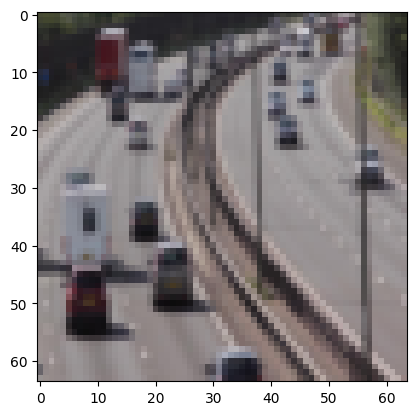

In [61]:
class VehicleDataset(Dataset):
    def __init__(self,image_dir,label_dir,transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = sorted(os.listdir(label_dir))
    
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.image_dir, self.image_files[idx]))
        #Convert color to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, 0

def display_sample(image):
    #Displays sample image from dataset
    image = image.permute(1,2,0).numpy()
    image = (image + 1) / 2
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    plt.show()


train_images = "../Vehicle_Detection_Image_Dataset/train/images"

train_labels = "../Vehicle_Detection_Image_Dataset/train/labels"

valid_images = "../Vehicle_Detection_Image_Dataset/valid/images"

valid_labels = "../Vehicle_Detection_Image_Dataset/valid/labels"
        

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64,64)), #What model size
    transforms.ToTensor(),
    transforms.Normalize([.5,.5,.5],[.5,.5,.5])

])



train_dataset = VehicleDataset(train_images,train_labels,transform)
train_dataloader = DataLoader(train_dataset,batch_size=20,shuffle=True)

valid_dataset = VehicleDataset(valid_images,valid_labels,transform) #Oops, shouldn't be transforming the test dataset as well
valid_dataloader = DataLoader(valid_dataset,batch_size=20)
%matplotlib inline

display_sample(train_dataset[0][0])


In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
kld_weight = .00025
lr = .005
latent_dimension = 1000
model = VanillaVAE(3,latent_dimension,hidden_dims=None)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=.005)

num_epochs = 30

In [66]:


for epoch in range(num_epochs):
    model.train()
    for images, _ in train_dataloader:
        images = images.to(device)

        recons, input, mu, log_var = model(images)
        loss_dict = model.loss_function(recons, input, mu, log_var,kld_weight)

        optimizer.zero_grad()

        loss_dict["loss"].backward()

        optimizer.step()
    avg_test_loss_dict =  {'loss': 0, 'Reconstruction_Loss':0, 'KLD':0}
    count = 0
    model.eval()
    with torch.inference_mode():
        for images, _ in valid_dataloader:
            images = images.to(device)
            recons, input, mu, log_var = model(images)

            loss_dict = model.loss_function(recons, input, mu, log_var,kld_weight)
            
            avg_test_loss_dict["loss"] += loss_dict["loss"]
            avg_test_loss_dict["Reconstruction_Loss"] += loss_dict["Reconstruction_Loss"]
            avg_test_loss_dict["KLD"] += loss_dict["KLD"]

            count += 1
        avg_test_loss_dict["loss"] /= count
        avg_test_loss_dict["Reconstruction_Loss"]  /= count
        avg_test_loss_dict["KLD"]  /= count
    if epoch % 3 == 0:
        print(f" Epoch: {epoch+1}: {avg_test_loss_dict}")
        image = valid_dataset[0][0].to(device)[np.newaxis,:,:,:]
        reconstructed_image = torch.squeeze(model.generate(image)).to("cpu").detach()
        display_sample(torch.squeeze(reconstructed_image))  


print("Training Complete")


 Epoch: 1: {'loss': tensor(0.1981, device='cuda:0'), 'Reconstruction_Loss': tensor(0.1488, device='cuda:0'), 'KLD': tensor(-196.9638, device='cuda:0')}


ValueError: expected 4D input (got 3D input)

torch.Size([1, 3, 64, 64])


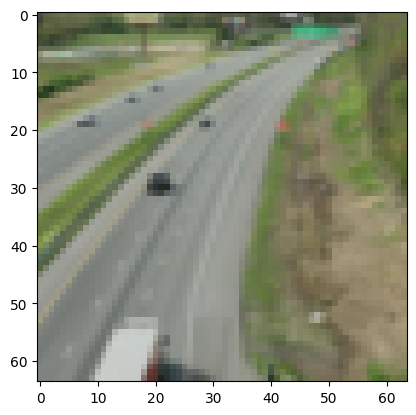

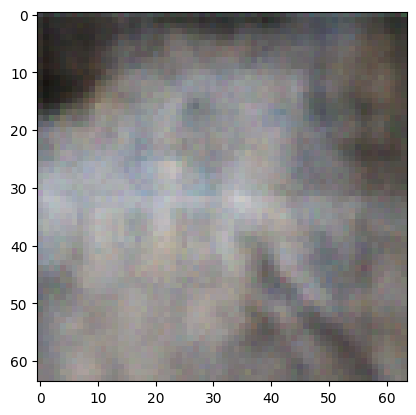

tensor([[[-0.4804, -0.6155, -0.5507,  ..., -0.5622, -0.4519, -0.5137],
         [-0.6218, -0.6507, -0.6491,  ..., -0.6346, -0.6400, -0.5906],
         [-0.6357, -0.7207, -0.6174,  ..., -0.6308, -0.6562, -0.6096],
         ...,
         [ 0.0787,  0.0234, -0.0094,  ..., -0.0356, -0.0253, -0.0734],
         [-0.0103,  0.0077,  0.0392,  ..., -0.0293, -0.0198, -0.0528],
         [ 0.0279,  0.0151, -0.0026,  ..., -0.0779,  0.0403, -0.0414]],

        [[-0.4753, -0.5728, -0.6101,  ..., -0.4493, -0.5655, -0.2948],
         [-0.6035, -0.7234, -0.6455,  ..., -0.6184, -0.6207, -0.6245],
         [-0.6263, -0.7071, -0.6409,  ..., -0.5766, -0.6082, -0.5791],
         ...,
         [-0.0446, -0.0346, -0.0263,  ..., -0.0123, -0.0667, -0.1115],
         [-0.0056, -0.0298, -0.0156,  ..., -0.0329, -0.0195, -0.0646],
         [-0.0331, -0.0283, -0.0366,  ..., -0.0729, -0.0147, -0.0530]],

        [[-0.4194, -0.6076, -0.5361,  ..., -0.5381, -0.5223, -0.4773],
         [-0.6423, -0.7322, -0.6740,  ..., -0

In [62]:
image = valid_dataset[20][0][np.newaxis,:,:,:].to(device)
print(image.shape)
reconstructed_image = torch.squeeze(model.generate(image)).to("cpu").detach()
display_sample(torch.squeeze(image.to("cpu")))
display_sample(reconstructed_image)
print(reconstructed_image)

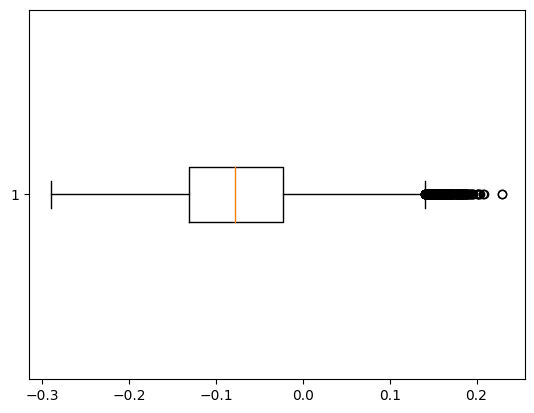

In [54]:
plt.boxplot(reconstructed_image.view(-1),vert=False)
plt.show()